In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import docker
from io import StringIO
import os.path

# Import one methods from other file
from dl_routines import *


client = docker.from_env()
client.containers.list()
container=client.containers.get("datalab_s22")
container.attach()

path="../code/assignment/"

t=180
dt=1/4096
N=180/dt
sigma=25

filename = "data_02.csv"

Plot the signal

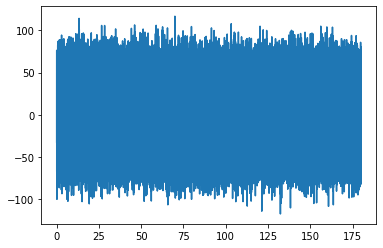

In [2]:
data=pd.read_csv(path+filename,delimiter=' ',header=None)
plt.plot(data[0],data[1])

***First analysis***

at first do a analysis with method 3 fourier transformation because it is best

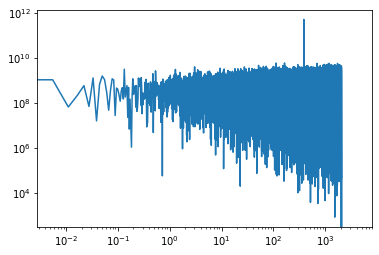

In [3]:
df_m3 = method_three(filename)
plt.plot(df_m3[0],df_m3[2])
plt.xscale("log")
plt.yscale("log")
plt.show()

Get the frequency stepsize from the fourier sprectrum

In [4]:
dfreq = df_m3[0][1]-df_m3[0][0]
dfreq

0.00555648

Get an overview over the range where the maximum peak lays

In [5]:
df_m3_sort = df_m3.sort_values(by=[2],ascending=False)
df_m3_sort

,0,1,2
69354,385.364,0,5.065060e+11
29443,163.599,0,5.914840e+09
20392,113.308,0,5.847850e+09
212957,1183.290,0,5.708960e+09
124672,692.737,0,5.662160e+09
...,...,...,...
491517,2731.100,0,0.000000e+00
491516,2731.100,0,0.000000e+00
491515,2731.090,0,0.000000e+00
491514,2731.090,0,0.000000e+00


In [6]:
df_m3.loc[69344:69364]

,0,1,2
69344,385.309,0,8.669450e+08
69345,385.314,0,3.007410e+08
69346,385.320,0,5.922980e+07
69347,385.325,0,6.066530e+08
69348,385.331,0,4.425200e+08
69349,385.336,0,5.123570e+08
69350,385.342,0,2.817330e+07
69351,385.347,0,1.199410e+07
69352,385.353,0,5.485940e+08
69353,385.359,0,6.327160e+08


The biggest frequeny is very clear so i just choose one

In [7]:
freq  = df_m3[0][df_m3[2].idxmax(0)]
freq

385.364

***Templatebank and probing***

create template bank in range of the just determined frequency

because there is only one possible frequency intervall we can directly make the runtime analysis
We do a square of:

In [8]:
freqs = int(2*dfreq/1e-3)
phis = 1117
createTemplateBank(filename,freqs,freq-dfreq,freq+dfreq,phis)
freqs * phis

12287

Runtime analysis

Take the time for probing of one element of the template bank

In [9]:
%%timeit -n100 -r3
prober(filename,method=1,freq_prober=freq,phi=0)

405 ms ± 44.2 ms per loop (mean ± std. dev. of 3 runs, 100 loops each)


thus we expect a runtime of:

In [10]:
print(freqs * phis * 0.449 / 60, "minutes")

91.94771666666666 minutes


which from experience is way to high. It is probably because of the time it take to call the function and the reason that prober with a template bank is way more optimised.

do an analysis for frequency, phase and amplitude with method 1 scalar product (takes about 3-4 min):

In [11]:
%%time
prober_tb(filename,1,filename)

CPU times: user 13.1 ms, sys: 10.5 ms, total: 23.7 ms
Wall time: 2min 36s


ExecResult(exit_code=0, output=b'')

visualize the result

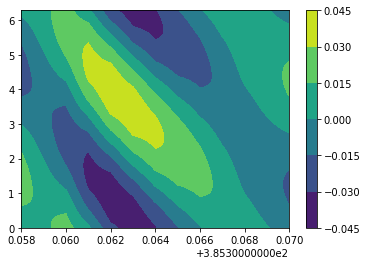

(385.362, 4.02552, 0.0814362)

In [12]:
df = proberToDf(filename,True)
(a ,b)  = (df[0].drop_duplicates(),df[1].drop_duplicates())
plt.contourf(a,b,df[2].values.reshape(len(b.index),len(a.index)))
plt.colorbar()
plt.show()
idmax = df[2].idxmax()
freq = df[0][idmax]
phase = df[1][idmax]
ampl = df[2][idmax]*2
(freq,phase,ampl)

the solution is not very sharp. Problem is, that prober cannot take smaller frequency steps when the frequency is high

Dataframe of (df, dphi, mismatch)_i

In [13]:
mismatch=1-df[2]/ampl*2
d = {'df': np.abs(df[0]-freq), 'dp':np.abs(df[1]-phase),'mismatch':mismatch}
mismatch = pd.DataFrame(data=d)
mismatch

,df,dp,mismatch
0,0.004,4.02552,0.916675
1,0.002,4.02552,0.487009
2,0.001,4.02552,0.930162
3,0.000,4.02552,1.635617
4,0.001,4.02552,1.940309
...,...,...,...
12282,0.003,2.25767,1.394279
12283,0.004,2.25767,1.026187
12284,0.005,2.25767,0.772422
12285,0.006,2.25767,0.790632


***ROC curve***

Generate Noise and multiple signals with above parameters

In [14]:
for i in range(0,100):
    if not os.path.isfile(path+getFileName(N,sigma,0,deltaT=dt)+"_"+str(i)):
        filename = getFileName(N=N,sigma=sigma,amplitude=0,deltaT=dt)+"_"+str(i)
        generate_source(N=N,sigma=sigma,amplitude=0,deltaT=dt,filename=filename)
        
for i in range(0,100):
    if not os.path.isfile(path+getFileName(N,sigma,ampl,freq,deltaT=dt,phase=phase)+"_"+str(i)):
        filename = getFileName(N=N,sigma=sigma,amplitude=ampl,freq=freq,deltaT=dt,phase=phase)+"_"+str(i)
        generate_source(N=N,sigma=sigma,amplitude=ampl,freq=freq,deltaT=dt,phase=phase,filename=filename)

probe the generated signals

In [15]:
probeN=[float(method_one(getFileName(N,sigma,0,deltaT=dt)+"_"+str(i),freq,phase)[2])/ampl*2 for i in range(0,100)]
probeS=[float(method_one(getFileName(N,sigma,ampl,freq,dt,phase)+"_"+str(i),freq,phase)[2])/ampl*2 for i in range(0,100)]

In [16]:
ampl

0.0814362

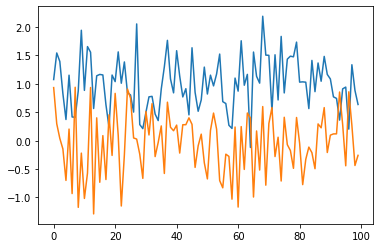

In [17]:
plt.plot(probeS)
plt.plot(probeN)
plt.show()

Plot histograms

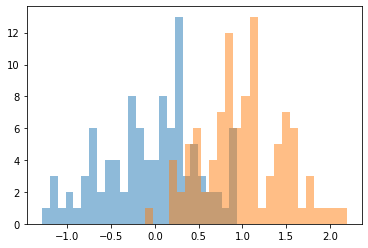

In [18]:
plt.hist(probeN,bins=25,alpha=0.5)
plt.hist(probeS,bins=25,alpha=0.5)
plt.show()

Generate ROC curve

In [19]:
roc = compute_thresholds(probeS,probeN)
roc

,threshold,false positives,true positives
0,-1.000000,94,100
1,-0.979798,93,100
2,-0.959596,93,100
3,-0.939394,93,100
4,-0.919192,92,100
...,...,...,...
95,0.919192,3,54
96,0.939394,1,54
97,0.959596,0,53
98,0.979798,0,51


Plot the roc curve and get the threshold.

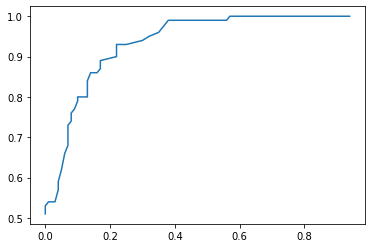

0.5555555555555556

In [20]:
roc_curve(probeS,probeN)

With this threshold about 82/100 times the signal gets detected, while 13/100 times noise gets detected as a signal.

In [22]:
roc[77:78]

,threshold,false positives,true positives
77,0.555556,13,82


Problem here is, that the amplitude is very small and thus cannot be detected very well.